# wine_reviews_deeplearning

Continuation of the `wine_reviews` notebook, but now with an applications of Deep Learning NLP methods, such as word embeddings, LSTM etc. <br>
Rybczyński Jędrzej, 17.08.2022

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

## Features Engineering

In [2]:
df = pd.read_csv('wine-reviews.csv')
df = df[['description', 'points']]
df = df.drop_duplicates().reset_index(drop=True)

In [3]:
def points_binning(points):
    if points >= 80 and points <= 84:
        return 1
    elif points >= 85 and points <= 89:
        return 2 
    elif points >= 90 and points <= 94:
        return 3 
    elif points >= 95 and points <= 100:
        return 4
    
df['points'] = df['points'].apply(points_binning)
df

,description,points
0,This tremendous 100% varietal wine hails from ...,4
1,"Ripe aromas of fig, blackberry and cassis are ...",4
2,Mac Watson honors the memory of a wine once ma...,4
3,"This spent 20 months in 30% new French oak, an...",4
4,"This is the top wine from La Bégude, named aft...",4
...,...,...
97826,A Syrah-Grenache blend that's dry and rustical...,1
97827,Oreo eaters will enjoy the aromas of this wine...,1
97828,"Outside of the vineyard, wines like this are w...",1
97829,"Heavy and basic, with melon and pineapple arom...",1


## Text preprocessing

### Lower Casing

In [4]:
df['description'] = df['description'].str.lower()

### Punctuations Removal

In [5]:
import string
import re

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_punctuation_extra(text):
    text = re.sub('[—-]', ' ', text)
    text = re.sub('[”“]', '', text)
    return text

df['description'] = df['description'].apply(remove_punctuation_extra)
df['description'] = df['description'].apply(remove_punctuation)

### Stopwords removal

In [6]:
import nltk

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    removed = [i for i in text.split() if i not in stopwords]
    return removed

df['description'] = df['description'].apply(remove_stopwords)
df['description'] = df['description'].str.join(' ')

In [7]:
df.head()

,description,points
0,tremendous 100 varietal wine hails oakville ag...,4
1,ripe aromas fig blackberry cassis softened swe...,4
2,mac watson honors memory wine made mother trem...,4
3,spent 20 months 30 new french oak incorporates...,4
4,top wine la bégude named highest point vineyar...,4


## t-SNE EDA

In [8]:
from gensim.models import Word2Vec

desc_tokenized = df.apply(lambda row: nltk.word_tokenize(row['description']), axis=1)
desc_tokenized

0        [tremendous, 100, varietal, wine, hails, oakvi...
1        [ripe, aromas, fig, blackberry, cassis, soften...
2        [mac, watson, honors, memory, wine, made, moth...
3        [spent, 20, months, 30, new, french, oak, inco...
4        [top, wine, la, bégude, named, highest, point,...
                               ...                        
97826    [syrah, grenache, blend, thats, dry, rusticall...
97827    [oreo, eaters, enjoy, aromas, wine, sweet, mil...
97828    [outside, vineyard, wines, like, built, compan...
97829    [heavy, basic, melon, pineapple, aromas, full,...
97830    [smooth, mouth, chard, starts, citrus, dust, a...
Length: 97831, dtype: object

In [9]:
model = Word2Vec(desc_tokenized, vector_size=100, window=20, min_count=2000, workers=4)


print(model)
print(list(model.wv.key_to_index)[:5])
print(model.wv.get_vector('wine'))

Word2Vec(vocab=231, vector_size=100, alpha=0.025)
['wine', 'flavors', 'fruit', 'finish', 'aromas']
[ 0.05293979 -0.069604   -0.24968165  0.38706672 -0.22460264  0.0282856
  0.7629786  -0.93210137  0.8651926  -0.03627657  0.44458878  0.07717934
 -0.8950221   0.24655765  0.06675486  0.36866447  0.61595356  0.6086
 -1.4750655  -0.32112685  1.2122827   0.24098207  0.44359586 -0.15431851
 -0.9116428  -0.5503878   0.58588606  1.6961346   0.3498517   0.64959717
 -0.35618985 -0.6798281   0.35799456  0.59999216 -0.16758488 -0.07638726
  0.9110921  -0.6509457   0.45628503 -0.3176565  -0.61431724  0.54328346
 -1.1448957  -0.2524335   0.03370296 -0.366877    0.785526    0.5850819
 -0.9257842  -0.1829314   0.30932325 -0.2059952  -0.8629119   0.2701557
  0.30662584 -0.16157655 -0.88379806 -0.49080282 -0.20748542  0.79094875
  0.74425787 -0.2538417  -0.24226515  0.26187542  0.05257668 -0.18775263
  0.47578     0.28090352  0.8171763  -0.7225059   0.57396764  0.08261468
  1.131083   -0.04678708 -0.5979

In [66]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it, source "
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\jrybczyn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jrybczyn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


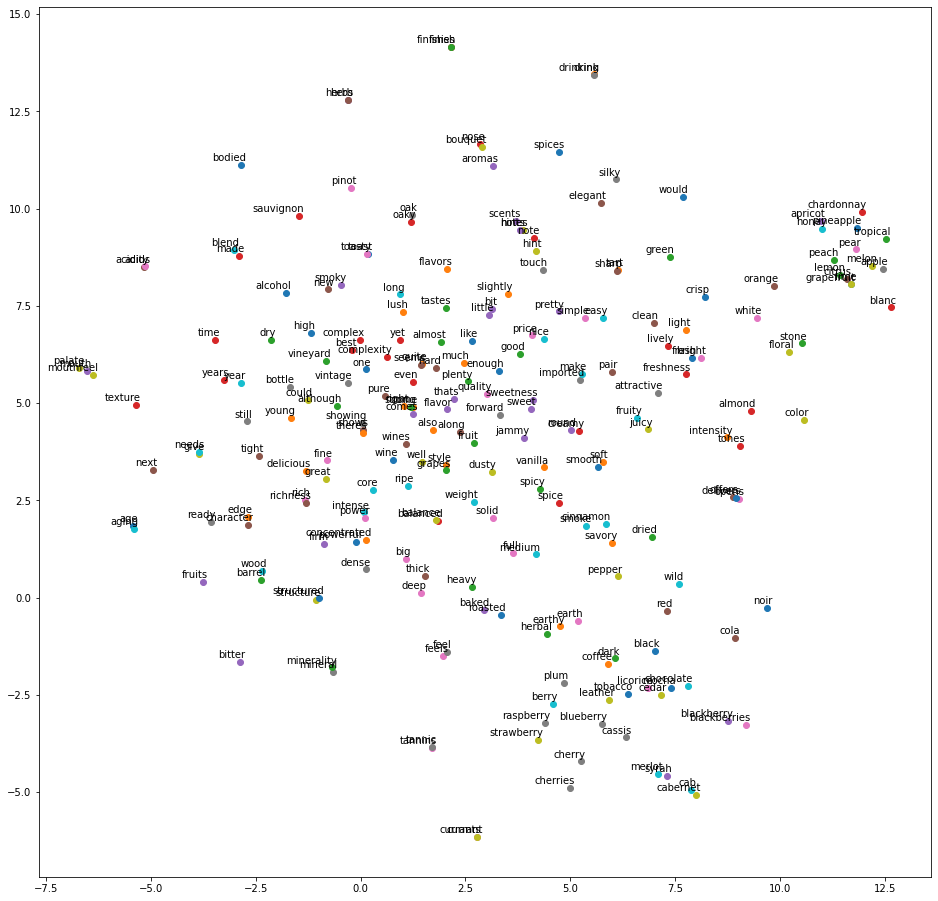

In [11]:
model = Word2Vec(desc_tokenized, vector_size=100, window=20, min_count=2000, workers=4)
tsne_plot(model)

Word2Vec(vocab=149, vector_size=100, alpha=0.025)


C:\Users\jrybczyn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jrybczyn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


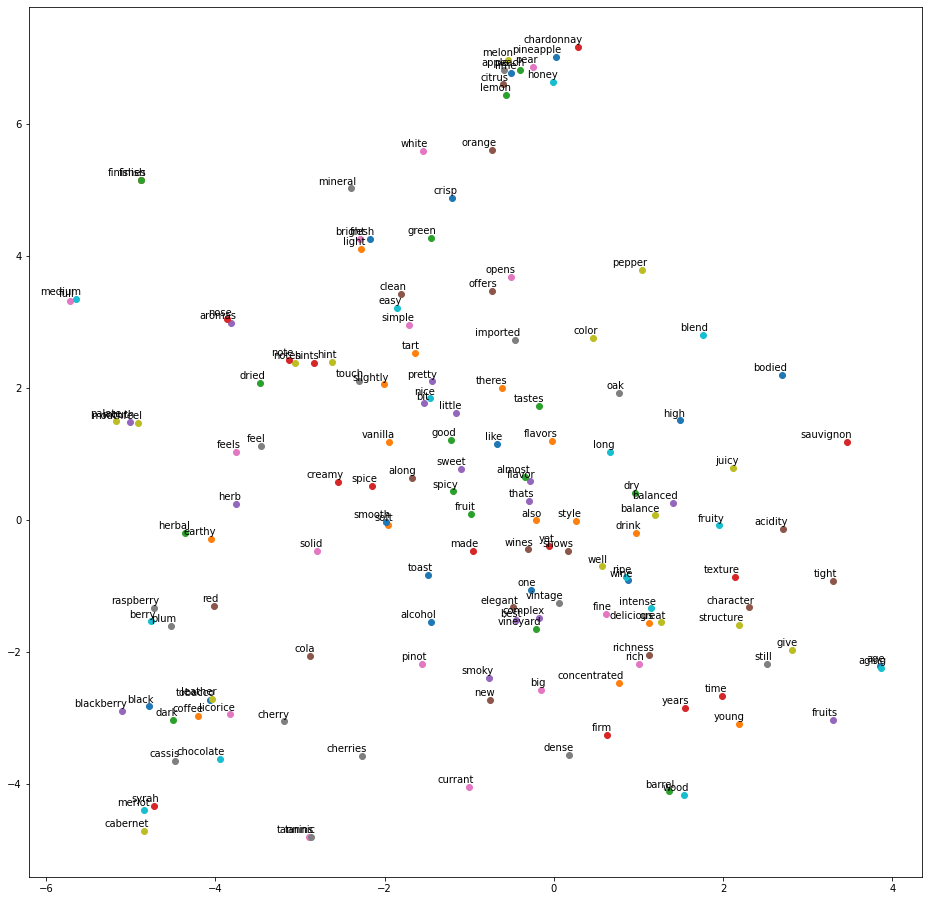

In [68]:
model = Word2Vec(desc_tokenized, vector_size=100, window=20, min_count=3000, workers=4)
print(model)
tsne_plot(model)

## Pretrained Word2Vec Embedding

In [13]:
word2vec_embedding = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
word2vec_embedding

In [378]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['description'])
VOCAB_SIZE=len(tokenizer.word_index) + 1

# integer encode the documents
encoded_docs = tokenizer.texts_to_sequences(df['description'])

In [379]:
# pad documents
MAX_LENGTH=df['description'].str.split().str.len().max()
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')
padded_docs

array([[ 1589,   340,   347, ...,     0,     0,     0],
       [   10,     5,   497, ...,     0,     0,     0],
       [15626, 19904,  6919, ...,     0,     0,     0],
       ...,
       [ 2562,   103,    76, ...,     0,     0,     0],
       [  193,   496,   139, ...,     0,     0,     0],
       [   61,    45,   490, ...,     0,     0,     0]])

In [380]:
# create a weight matrix for words in training docs
EMBEDDING_DIM=300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in word2vec_embedding.key_to_index:
        embedding_matrix[i] = word2vec_embedding[word]

In [381]:
list(tokenizer.word_index)[:15]

['wine',
 'flavors',
 'fruit',
 'finish',
 'aromas',
 'acidity',
 'tannins',
 'cherry',
 'palate',
 'ripe',
 'black',
 'drink',
 'dry',
 'spice',
 'sweet']

In [286]:
X = padded_docs
y = pd.get_dummies(df['points'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## LSTM Neural Network Model (Word2Vec)

In [41]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))

model.add(LSTM(100, return_sequences=True, dropout=0.2))
model.add(GlobalMaxPooling1D())

# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Bidirectional(LSTM(25, return_sequences=True)))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu', kernel_regularizer='L1L2'))
# model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 83, 300)           9985200   
                                                                 
 lstm_2 (LSTM)               (None, 83, 100)           160400    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 10,146,004
Trainable params: 160,804
Non-trainable params: 9,985,200
_________________________________________________________________


In [42]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [106]:
EPOCHS = 10
BATCH_SIZE = 32
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)

Epoch 1/10
2446/2446 [==============================] - 374s 152ms/step - loss: 0.7107 - acc: 0.6880 - val_loss: 0.6831 - val_acc: 0.7024
Epoch 2/10
2446/2446 [==============================] - 361s 148ms/step - loss: 0.6284 - acc: 0.7240 - val_loss: 0.6134 - val_acc: 0.7289
Epoch 3/10
2446/2446 [==============================] - 334s 137ms/step - loss: 0.6000 - acc: 0.7373 - val_loss: 0.6083 - val_acc: 0.7344
Epoch 4/10
2446/2446 [==============================] - 322s 132ms/step - loss: 0.5768 - acc: 0.7475 - val_loss: 0.5917 - val_acc: 0.7409
Epoch 5/10
2446/2446 [==============================] - 327s 134ms/step - loss: 0.5559 - acc: 0.7581 - val_loss: 0.5924 - val_acc: 0.7398
Epoch 6/10
2446/2446 [==============================] - 335s 137ms/step - loss: 0.5376 - acc: 0.7676 - val_loss: 0.6082 - val_acc: 0.7324
Epoch 7/10
2446/2446 [==============================] - 344s 141ms/step - loss: 0.5200 - acc: 0.7751 - val_loss: 0.5926 - val_acc: 0.7424
Epoch 8/10
2446/2446 [============

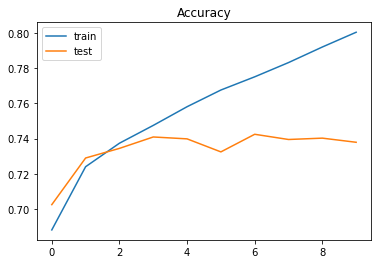

In [107]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

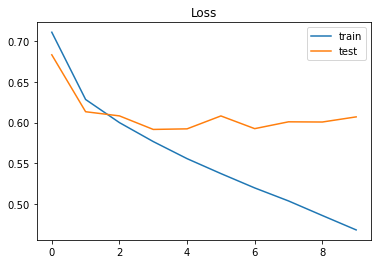

In [108]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [109]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1) + 1

print(classification_report(df['points'][y_test.index], prediction))

612/612 [==============================] - 14s 23ms/step
              precision    recall  f1-score   support

           1       0.72      0.66      0.69      2924
           2       0.76      0.79      0.77     10187
           3       0.72      0.72      0.72      6074
           4       0.51      0.28      0.36       382

    accuracy                           0.74     19567
   macro avg       0.68      0.61      0.63     19567
weighted avg       0.74      0.74      0.74     19567



## Pretrained GloVe Embedding

In [19]:
# load the whole embedding into memory
glove_embedding = dict()
f = open('glove.6B/glove.6B.300d.txt', encoding='utf8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embedding[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(glove_embedding))

Loaded 400000 word vectors.


In [20]:
# create a weight matrix for words in training docs
EMBEDDING_DIM=300
embedding_matrix_glove = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in glove_embedding.keys():
        embedding_matrix_glove[i] = glove_embedding[word]

## LSTM Neural Network Model (GloVe)

In [82]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix_glove], input_length=MAX_LENGTH, trainable=False))

model.add(LSTM(100, return_sequences=True, dropout=0.2))
model.add(GlobalMaxPooling1D())

# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Bidirectional(LSTM(25, return_sequences=True)))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu', kernel_regularizer='L1L2'))
# model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 83, 300)           9985200   
                                                                 
 lstm_2 (LSTM)               (None, 83, 100)           160400    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 10,146,004
Trainable params: 160,804
Non-trainable params: 9,985,200
_________________________________________________________________


In [83]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [84]:
EPOCHS = 10
BATCH_SIZE = 32
es = EarlyStopping(monitor='val_acc', patience=2, verbose=1, restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[es]
)

Epoch 1/10
2446/2446 [==============================] - 195s 77ms/step - loss: 0.6947 - acc: 0.6947 - val_loss: 0.6250 - val_acc: 0.7248
Epoch 2/10
2446/2446 [==============================] - 186s 76ms/step - loss: 0.6063 - acc: 0.7361 - val_loss: 0.6009 - val_acc: 0.7376
Epoch 3/10
2446/2446 [==============================] - 181s 74ms/step - loss: 0.5709 - acc: 0.7529 - val_loss: 0.5910 - val_acc: 0.7416
Epoch 4/10
2446/2446 [==============================] - 181s 74ms/step - loss: 0.5443 - acc: 0.7644 - val_loss: 0.5935 - val_acc: 0.7423
Epoch 5/10
2446/2446 [==============================] - 172s 70ms/step - loss: 0.5216 - acc: 0.7756 - val_loss: 0.5905 - val_acc: 0.7463
Epoch 6/10
2446/2446 [==============================] - 177s 72ms/step - loss: 0.4977 - acc: 0.7847 - val_loss: 0.6032 - val_acc: 0.7384
Epoch 7/10
2446/2446 [==============================] - 183s 75ms/step - loss: 0.4791 - acc: 0.7950 - val_loss: 0.6027 - val_acc: 0.7424
Epoch 7: early stopping


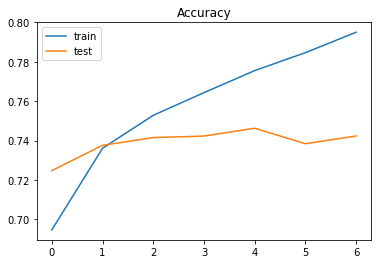

In [85]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

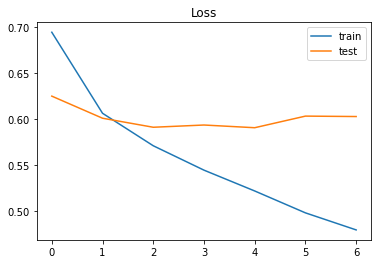

In [86]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [87]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1) + 1

print(classification_report(df['points'][y_test.index], prediction))

612/612 [==============================] - 15s 23ms/step
              precision    recall  f1-score   support

           1       0.74      0.66      0.70      2924
           2       0.76      0.81      0.78     10187
           3       0.74      0.71      0.72      6074
           4       0.48      0.43      0.45       382

    accuracy                           0.75     19567
   macro avg       0.68      0.65      0.66     19567
weighted avg       0.75      0.75      0.74     19567



In [89]:
model.save('lstm_glove')

INFO:tensorflow:Assets written to: lstm_glove\assets


INFO:tensorflow:Assets written to: lstm_glove\assets


## Learning own Embedding

It was trained on Azure ML studio, only loading model.

In [135]:
from keras.models import load_model

model = load_model('own_embb_model/') 

In [134]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1) + 1

print(classification_report(df['points'][y_test.index], prediction))

612/612 [==============================] - 36s 59ms/step
              precision    recall  f1-score   support

           1       0.69      0.61      0.65      2924
           2       0.73      0.78      0.75     10187
           3       0.71      0.66      0.68      6074
           4       0.42      0.37      0.40       382

    accuracy                           0.71     19567
   macro avg       0.64      0.61      0.62     19567
weighted avg       0.71      0.71      0.71     19567



## Stacking CatBoost & LSTM GloVe attempt

In [72]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier()
cb.load_model('catboost_model')

In [298]:
df_catboost = pd.read_pickle('catboost_df')

X = df_catboost.drop(columns='points')
y = df_catboost['points']
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [300]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_catboost['description'])
VOCAB_SIZE=len(tokenizer.word_index) + 1

encoded_docs = tokenizer.texts_to_sequences(df_catboost['description'])
MAX_LENGTH=df_catboost['description'].str.split().str.len().max()
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')

X = padded_docs
y = pd.get_dummies(df_catboost['points'])
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [308]:
cb_pred_proba = cb.predict_proba(X_test_cb)
lstm_pred_proba = model.predict(X_test_lstm)

612/612 [==============================] - 14s 22ms/step


In [353]:
stacking_pred_proba = 0.9 * cb_pred_proba + 0.1 * lstm_pred_proba
prediction = np.argmax(stacking_pred_proba, axis=1) + 1

In [354]:
print(classification_report(y_test_cb, prediction))

              precision    recall  f1-score   support

           1       0.80      0.64      0.71      2925
           2       0.78      0.85      0.81     10188
           3       0.78      0.76      0.77      6075
           4       0.61      0.31      0.41       383

    accuracy                           0.78     19571
   macro avg       0.74      0.64      0.68     19571
weighted avg       0.78      0.78      0.78     19571



In [401]:
y_test_merged = y_test.merge(y_test_cb, left_index=True, right_index=True, how='inner')
y_test_merged = y_test_merged['points'].sort_index()

X_test_lstm = pd.DataFrame(X_test, index=y_test.index)
X_test_lstm = X_test_lstm[X_test_lstm.index.isin(y_test_merged.index)].sort_index()
X_test_lstm = X_test_lstm.to_numpy()

X_test_cb = X_test_cb[X_test_cb.index.isin(y_test_merged.index)].sort_index()

cb_pred_proba = cb.predict_proba(X_test_cb)
lstm_pred_proba = model.predict(X_test_lstm)

stacking_pred_proba = 0.7 * cb_pred_proba + 0.3 * lstm_pred_proba
prediction = np.argmax(stacking_pred_proba, axis=1) + 1

print(classification_report(y_test_merged, prediction))

125/125 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

           1       0.85      0.64      0.73       583
           2       0.79      0.88      0.83      2075
           3       0.80      0.78      0.79      1250
           4       0.74      0.30      0.43        76

    accuracy                           0.80      3984
   macro avg       0.80      0.65      0.70      3984
weighted avg       0.80      0.80      0.80      3984

